__Black Scholes Model__

Black Scholes model is based on number of assumptions about how financial markets operate and those are:

Arbitrage Free Markets
Frictionless and Continuous Markets
Risk Free Rates
Log-normally Distributed Price Movements
Constant Volatility
These assumptions maynot hold true in reality, but are not particularly limiting. The generalized Black Scholes framework have been extended to price derivaties of other asset classes such as Black 76 (Commodity Futures) and Garman-Kohlhagen (FX Futures) that are currently used in derivative pricing and risk management.

__Black Scholes Formula__

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0$$


Solving the above equation, we know that the value of a call option for a non-dividend paying stock is:

$$C = S N(d_1) - K e^{-rt} N(d_2)$$

$$P = K e^{-rt} N(-d_2) - S N(-d_1)$$


$$d_1 = \frac{1}{\sigma \sqrt{t}} \left[ \ln\left(\frac{S}{K}\right) + \left( r + \frac{\sigma^2}{2} \right) t \right]$$

$$d_2 = d_1 - \sigma \sqrt{t}$$

$$N(x) = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} e^{-\frac{1}{2}x^2} \, dx$$


S
 is the spot price of the underlying asset
 
K
 is the strike price
 
r
 is the annualized continuous compounded risk free rate
 
σ
 is the volatility of returns of the underlying asset
 
t
 is time to maturity (expressed in years)
 
N
(
x
)
 is the standard normal cumulative distribution

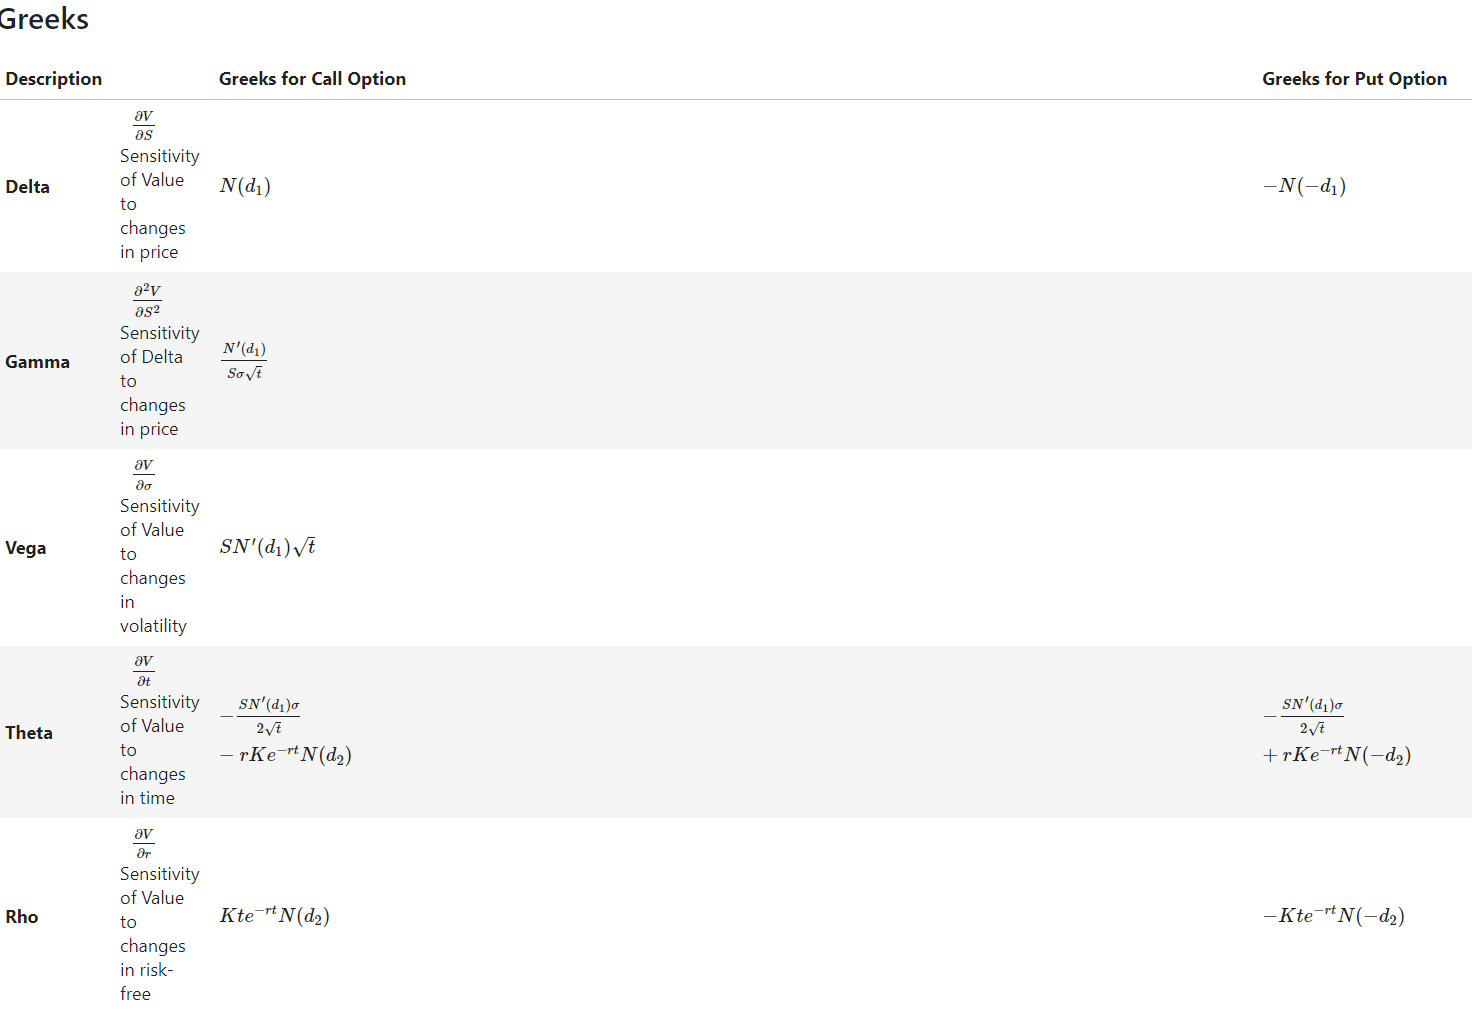

In [1]:
# install packages
%pip install matplotlib pydantic opstrat

  Using cached opstrat-0.1.7-py3-none-any.whl.metadata (8.8 kB)
  Using cached yfinance-0.2.43-py2.py3-none-any.whl.metadata (11 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached peewee-3.17.6-py3-none-any.whl
  Using cached html5lib-1.1-py2.py3-none-any.whl.metadata (16 kB)
Using cached opstrat-0.1.7-py3-none-any.whl (11 kB)
Using cached yfinance-0.2.43-py2.py3-none-any.whl (84 kB)
Using cached html5lib-1.1-py2.py3-none-any.whl (112 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Importing libraries
from pydantic import BaseModel, Field, computed_field
from typing import Literal
import numpy as np
from scipy.stats import norm
from datetime import datetime
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
from tabulate import tabulate

# Option Strategy plotting
import opstrat as op
import yfinance as yf

Options Object
Python is an object oriented programming language. Almost everything in Python is an object, with its properties and methods. There are two common programming paradigm in Python.

Procedural Programming
Object-oriented Programming (OOP)

The key difference between them is that in OOP, objects are at the center, not only representing the data, as in the procedural programming, but in the overall structure of the program as well.

Class
We use Classes to create user-defined data structures. Classes define functions called methods, which identify the characteristics and actions that an object created from the class can perform with its data. A Class is like an object constructor, or a "blueprint" for creating objects. To create a class, use the keyword class

Refer the below script using to model the Black-Scholes option pricing and Greeks for both call and put European options.

Pydantic is a Python library that allows you to define data models using Python classes and validate their instances. It provides a powerful and flexible way to work with data structures in Python, making it easier to create robust and maintainable code. We will use Pydantic to ensure type safety and input validation, and create two models as follows to build the option pricing and Greeks calculations.

OptionInputs for input validation and

BlackScholesModel for calculations.

In [3]:
#option Object Using pydantic
class OptionInputs(BaseModel):
    option_type: Literal["call", "put"]
    spot_price: float = Field(gt=0, description="Current price of the underlying asset")
    strike_price: float = Field(gt=0, description="Strike price of the option")
    time_to_expiry: float = Field(gt=0, description="Time to expiration in years")
    risk_free_rate: float = Field(ge=0, le=1, description="Risk-free interest rate")
    volatility: float = Field(gt=0, description="Volatility of the underlying asset")

class BlackScholesModel(BaseModel):
    inputs: OptionInputs

    @computed_field
    def d1(self) -> float:
        return (np.log(self.inputs.spot_price / self.inputs.strike_price) + 
                (self.inputs.risk_free_rate + 0.5 * self.inputs.volatility**2) * self.inputs.time_to_expiry) / \
               (self.inputs.volatility * np.sqrt(self.inputs.time_to_expiry))

    @computed_field
    def d2(self) -> float:
        return self.d1 - self.inputs.volatility * np.sqrt(self.inputs.time_to_expiry)

    @computed_field
    def price(self) -> float:
        if self.inputs.option_type == "call":
            return self.inputs.spot_price * norm.cdf(self.d1) - \
                   self.inputs.strike_price * np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(self.d2)
        else:  # put option
            return self.inputs.strike_price * np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(-self.d2) - \
                   self.inputs.spot_price * norm.cdf(-self.d1)

    @computed_field
    def delta(self) -> float:
        if self.inputs.option_type == "call":
            return norm.cdf(self.d1)
        else:  # put option
            return norm.cdf(self.d1) - 1

    @computed_field
    def gamma(self) -> float:
        return norm.pdf(self.d1) / (self.inputs.spot_price * self.inputs.volatility * np.sqrt(self.inputs.time_to_expiry))

    @computed_field
    def vega(self) -> float:
        return self.inputs.spot_price * norm.pdf(self.d1) * np.sqrt(self.inputs.time_to_expiry) / 100

    @computed_field
    def theta(self) -> float:
        common = -(self.inputs.spot_price * norm.pdf(self.d1) * self.inputs.volatility) / (2 * np.sqrt(self.inputs.time_to_expiry))
        if self.inputs.option_type == "call":
            return (common - self.inputs.risk_free_rate * self.inputs.strike_price * 
                    np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(self.d2)) / 365
        else:  # put option
            return (common + self.inputs.risk_free_rate * self.inputs.strike_price * 
                    np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(-self.d2)) / 365

    @computed_field
    def rho(self) -> float:
        if self.inputs.option_type == "call":
            return self.inputs.strike_price * self.inputs.time_to_expiry * np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(self.d2) / 100
        else:  # put option
            return -self.inputs.strike_price * self.inputs.time_to_expiry * np.exp(-self.inputs.risk_free_rate * self.inputs.time_to_expiry) * norm.cdf(-self.d2) / 100

__Example__

In [4]:
# Get the inputs for a option
call_option_inputs = OptionInputs(
    option_type="call",
    spot_price=100,
    strike_price=100,
    time_to_expiry=1,
    risk_free_rate=0.05,
    volatility=0.2
)

# Create a copy of the inputs with the option_type set to "put"
put_option_inputs = call_option_inputs.model_copy(update={"option_type": "put"})

# Create a BlackScholesModel object with the inputs
call_option = BlackScholesModel(inputs=call_option_inputs)
put_option = BlackScholesModel(inputs=put_option_inputs)


header = ['Option Type', 'Option Price', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
table = [
    [call_option_inputs.option_type, call_option.price, call_option.delta, call_option.gamma, call_option.theta, call_option.vega, call_option.rho],
    [put_option_inputs.option_type, put_option.price, put_option.delta, put_option.gamma, put_option.theta, put_option.vega, put_option.rho]
]

# Print the call option table
print(tabulate(table,header))

Option Type      Option Price      Delta     Gamma        Theta     Vega        Rho
-------------  --------------  ---------  --------  -----------  -------  ---------
call                 10.4506    0.636831  0.018762  -0.0175727   0.37524   0.532325
put                   5.57353  -0.363169  0.018762  -0.00454214  0.37524  -0.418905


__Option Payoff Visualization__

Traders construct option strategies ranging from buying or selling a single option to very complex ones that involve multiple simultaneous option positions. Option payoff diagrams are profit and loss charts that show the risk/reward profile of an option or combination of options. As option probability can be complex to understand, payoff diagrams gives an insight into the risk/reward for the trading strategy. Opstrat is a package for visualizing these Option payoffs.

__Example 1: Long Call Option__

A long call option is a strategy that involves buying the option of the underlying stock. The strategy is designed to profit from the upside in the underlying stock. The payoff diagram for this strategy can be plotted using the single_plotter() function. 

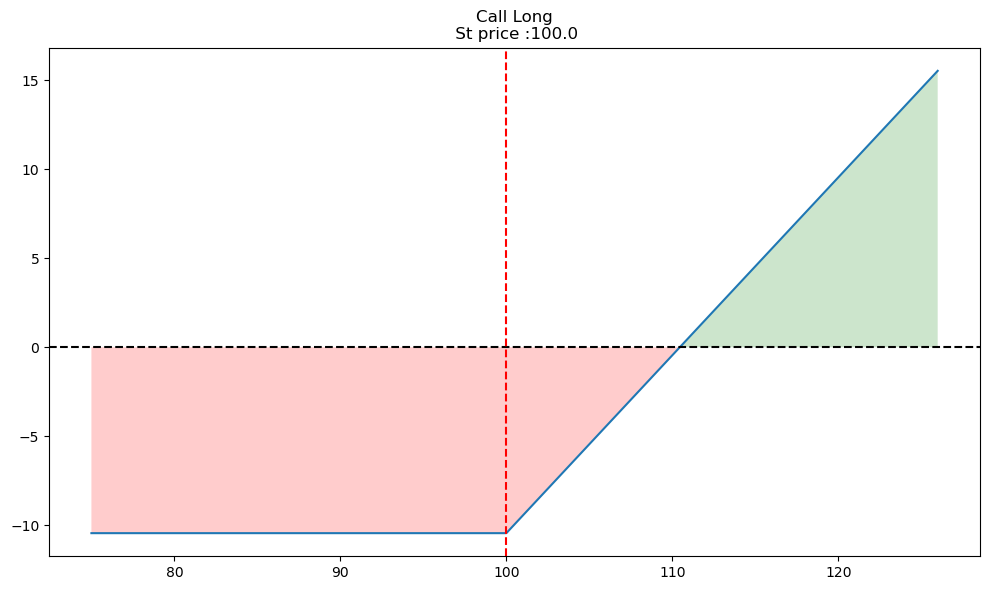

In [5]:
# Single Plotter
op.single_plotter(spot=call_option_inputs.spot_price, strike=call_option_inputs.strike_price, op_type='c', tr_type='b', op_pr=call_option.price, spot_range=25)


__Example 2: Short Straddle__

A short straddle is an options trading strategy that involves selling a call and a put option of the same underlying stock, strike and expiration date. The strategy is designed to profit from the difference in the prices of the two options. The payoff diagram for this strategy can be plotted using the multi_plotter() function. This function will plot each individual payoff diagrams and the resultant payoff diagram. The particulars of each option has to be provided as a list of dictionaries.

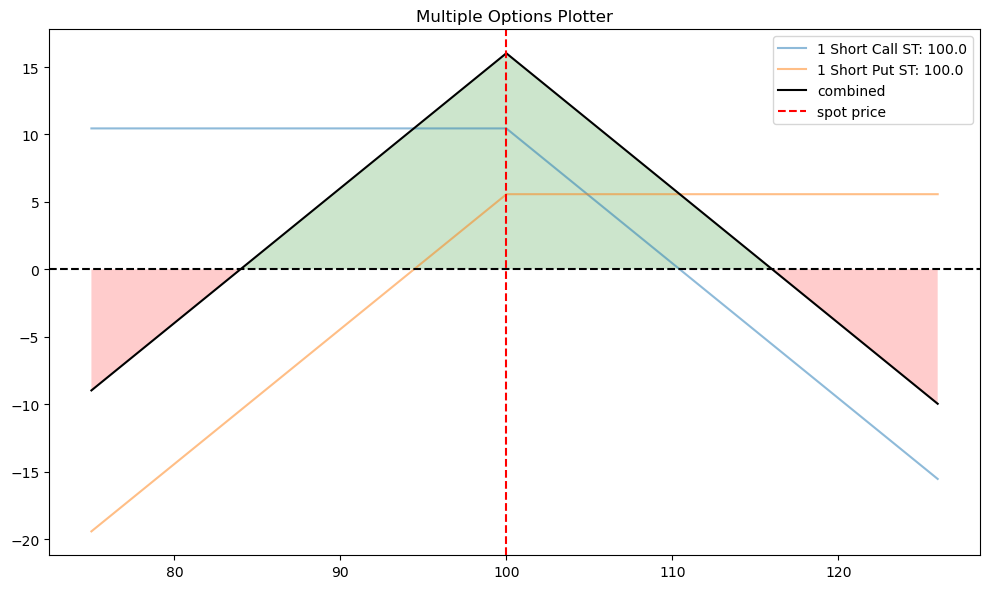

In [6]:
# Straddle
leg1 = BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=100,strike_price=100,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))
leg2 = BlackScholesModel(inputs=OptionInputs(option_type="put",spot_price=100,strike_price=100,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))

# The particulars of each option has to be provided as a list of dictionaries.
op_1 = {'op_type': 'c', 'strike':leg1.inputs.strike_price, 'tr_type': 's', 'op_pr': leg1.price}
op_2 = {'op_type': 'p', 'strike':leg2.inputs.strike_price, 'tr_type': 's', 'op_pr': leg2.price}
op_list = [op_1, op_2]

# Multi-plotter
op.multi_plotter(spot=leg1.inputs.spot_price, spot_range=25, op_list=op_list)


__Example 3: Short Strangle__

A short strangle is an options trading strategy that involves selling a call and a put option of the same underlying stock and expiration date. The strategy is designed to profit from the difference in the prices of the two options. The payoff diagram for this strategy can be plotted using the multi_plotter() function. This function will plot each individual payoff diagrams and the resultant payoff diagram. The particulars of each option has to be provided as a list of dictionaries.

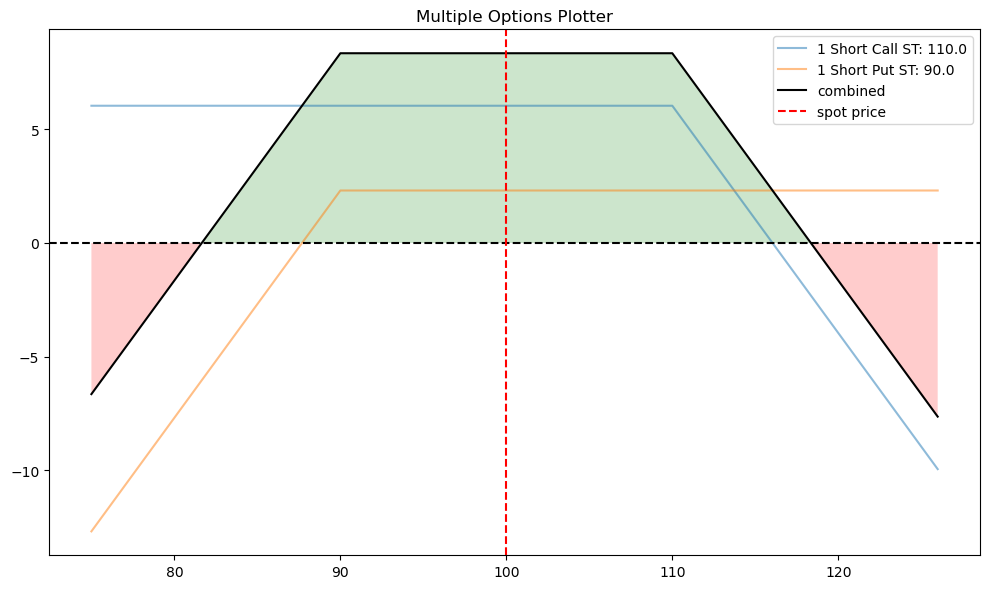

In [7]:
# Strangle
leg1 = BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=100,strike_price=110,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))
leg2 = BlackScholesModel(inputs=OptionInputs(option_type="put",spot_price=100,strike_price=90,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))

# The particulars of each option has to be provided as a list of dictionaries.
op_1 = {'op_type': 'c', 'strike':leg1.inputs.strike_price, 'tr_type': 's', 'op_pr': leg1.price}
op_2 = {'op_type': 'p', 'strike':leg2.inputs.strike_price, 'tr_type': 's', 'op_pr': leg2.price}
op_list = [op_1, op_2]

# Multi-plotter
op.multi_plotter(spot=leg1.inputs.spot_price, spot_range=25, op_list=op_list)

__Example 4: Iron condor__

An iron condor is an options strategy consisting of two puts (one long and one short) and two calls (one long and one short), and four strike prices, all with the same expiration date. The strategy is designed to profit from the difference in the option prices. The payoff diagram for this strategy can be plotted using the multi_plotter() function. This function will plot each individual payoff diagrams and the resultant payoff diagram. The particulars of each option has to be provided as a list of dictionaries.

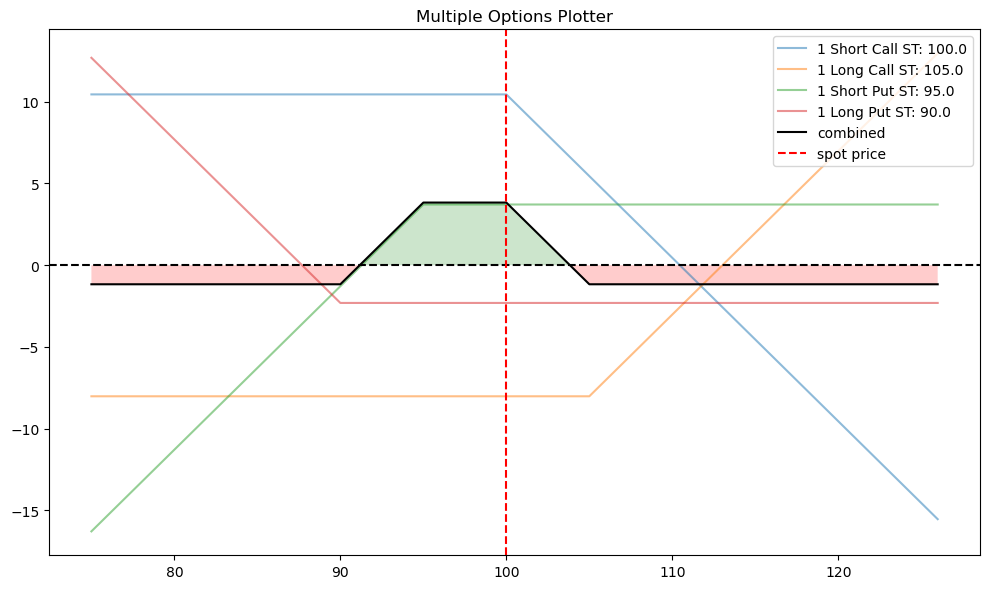

In [8]:
# Strangle
leg1 = BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=100,strike_price=100,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))
leg2 = BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=100,strike_price=105,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))
leg3 = BlackScholesModel(inputs=OptionInputs(option_type="put",spot_price=100,strike_price=95,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))
leg4 = BlackScholesModel(inputs=OptionInputs(option_type="put",spot_price=100,strike_price=90,time_to_expiry=1,risk_free_rate=0.05,volatility=0.2))


# The particulars of each option has to be provided as a list of dictionaries.
op_1 = {'op_type': 'c', 'strike':leg1.inputs.strike_price, 'tr_type': 's', 'op_pr': leg1.price}
op_2 = {'op_type': 'c', 'strike':leg2.inputs.strike_price, 'tr_type': 'b', 'op_pr': leg2.price}
op_3 = {'op_type': 'p', 'strike':leg3.inputs.strike_price, 'tr_type': 's', 'op_pr': leg3.price} 
op_4 = {'op_type': 'p', 'strike':leg4.inputs.strike_price, 'tr_type': 'b', 'op_pr': leg4.price}

op_list = [op_1, op_2, op_3, op_4]

# Multi-plotter
op.multi_plotter(spot=leg1.inputs.spot_price, spot_range=25, op_list=op_list)

__SPY Option__

Let's now retrieve SPY option price from Yahoo Finance using yfinance library and manipulate the dataframe using the above Black Scholes option pricing model that we created.

https://finance.yahoo.com/quote/SPY/options/?date=1727654400

In [9]:
# Get SPY option chain
spy = yf.Ticker('SPY')
options = spy.option_chain('2024-09-30')

In [10]:
# September 2024 533 SPY call option price
dte = (datetime(2024, 9, 30) - datetime.today()).days/365
spot = 532.905; strike = 533; rate = 0.0; dte = dte; vol = 0.2107

spy_opt =BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=spot,strike_price=strike,time_to_expiry=dte,risk_free_rate=rate,volatility=vol))
print(f'Option Price of SPY240930C00533000 with BS Model is {spy_opt.price:0.4f}')

Option Price of SPY240930C00533000 with BS Model is 8.4065


In [11]:
# Verify the options output
options.calls.head(2)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,SPY240930C00300000,2024-08-26 16:45:12+00:00,300.0,262.68,0.0,0.0,0.0,0.0,2.0,84,0.00001,True,REGULAR,USD
1,SPY240930C00305000,2024-09-06 14:42:37+00:00,305.0,238.42,0.0,0.0,0.0,0.0,2.0,122,0.00001,True,REGULAR,USD


In [14]:
# Filter calls for strike at or above 530
df = options.calls[(options.calls['strike']>=530) & (options.calls['strike']<=550)]
df.reset_index(drop=True, inplace=True)

# Dataframe manipulation with selected fields
df = pd.DataFrame({'Strike': df['strike'], 
                   'Price': df['lastPrice'], 
                   'ImpVol': df['impliedVolatility']})

# Derive greeks and assign to dataframe as columns
df['Delta'] = df['Gamma'] = df['Vega'] = df['Theta'] = 0.

for i in range(len(df)):

    option = BlackScholesModel(inputs=OptionInputs(option_type="call",spot_price=spot,strike_price=df['Strike'].iloc[i],time_to_expiry=dte,risk_free_rate=rate,volatility=df['ImpVol'].iloc[i]))
    
    df['Delta'].iloc[i] = option.delta
    df['Gamma'].iloc[i] = option.gamma
    df['Vega'].iloc[i] = option.vega
    df['Theta'].iloc[i] = option.theta

# Check output
df.head(2)

,Strike,Price,ImpVol,Delta,Gamma,Vega,Theta
0,530.0,33.34,0.00001,1.0,0.0,0.0,-0.0
1,531.0,31.21,0.00001,1.0,0.0,0.0,-0.0


__Visualize Data__

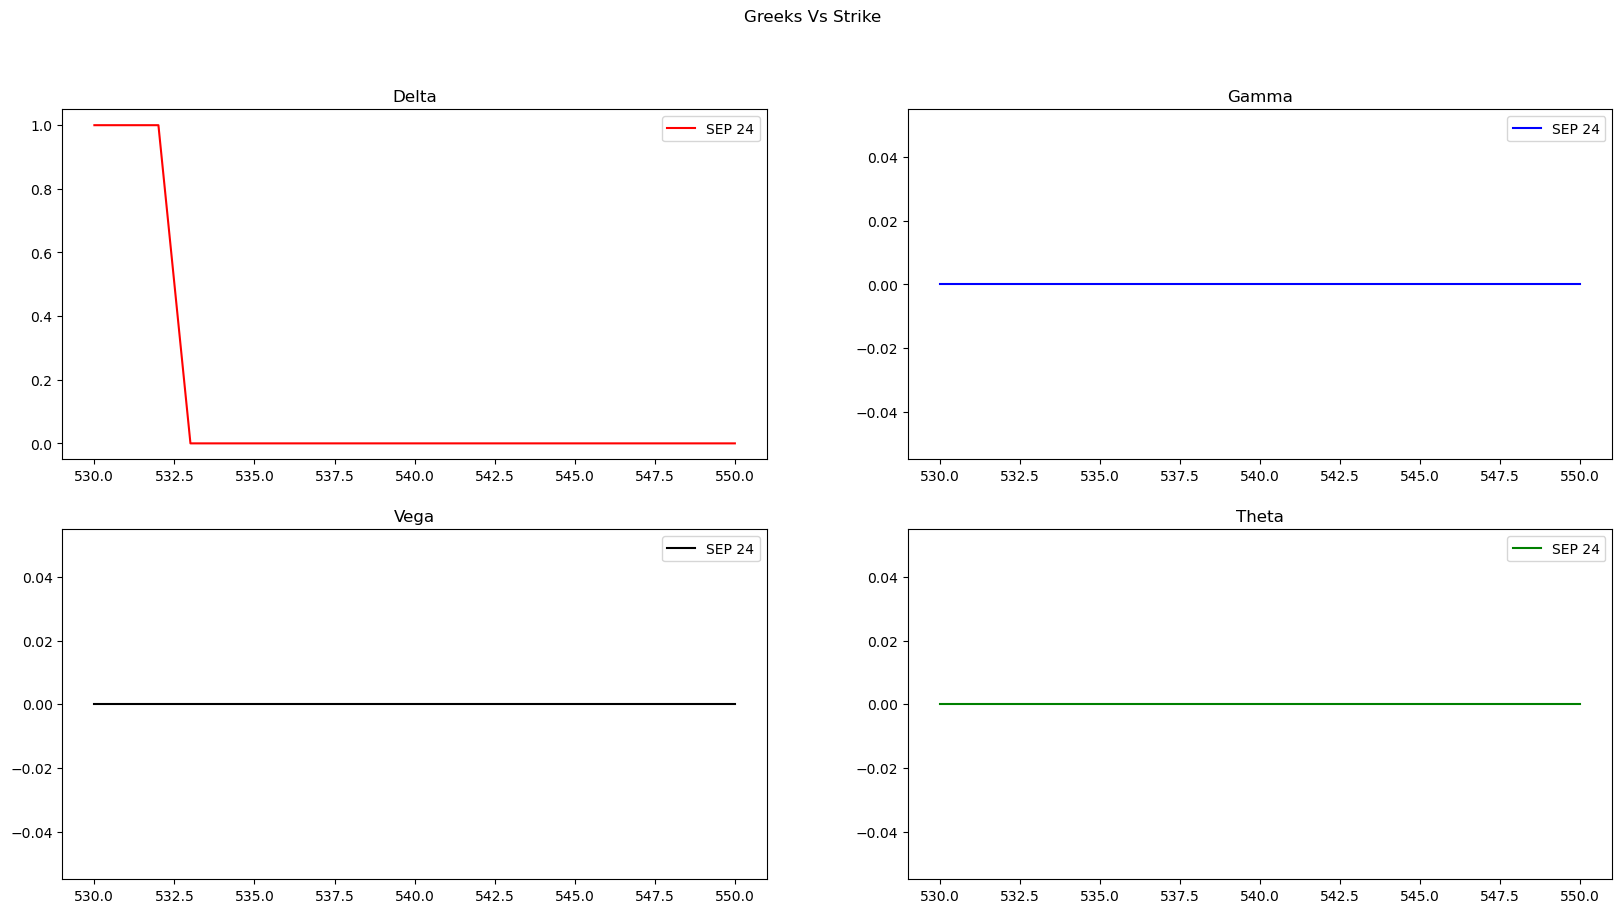

In [15]:
# Plot graph iteratively
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(df['Strike'], df['Delta'], color='r', label='SEP 24')
ax[0,1].plot(df['Strike'], df['Gamma'], color='b', label='SEP 24')
ax[1,0].plot(df['Strike'], df['Vega'],  color='k', label='SEP 24')
ax[1,1].plot(df['Strike'], df['Theta'], color='g', label='SEP 24')
    
# Set axis title
ax[0,0].set_title('Delta'), ax[0,1].set_title('Gamma'), ax[1,0].set_title('Vega'), ax[1,1].set_title('Theta')

# Define legend
ax[0,0].legend(), ax[0,1].legend(), ax[1,0].legend(), ax[1,1].legend()

# Set title
fig.suptitle('Greeks Vs Strike')

plt.show()